# DOE 本番解析用 (base) v6 移動平均・メジアン

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 初期設定

In [5]:
name_doe = "doe-13c"  # 実験計画名（フォルダ名）
path_doe = os.path.join("..", "doe", f"{name_doe}.csv")

# name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

df_doe = pd.read_csv(path_doe)
print(df_doe)
factor_doe = list(df_doe.columns)
print(factor_doe)
col_x = factor_doe[0]
col_y = factor_doe[1]

res = AppRes()
dict_setting = load_setting(res, name_code)
df_setting = pd.DataFrame(pd.Series(dict_setting))
df_setting.columns = ["value"]
print("\n設定")
print(df_setting)

x_por = dict_setting[col_x]
y_por = dict_setting[col_y]

# 移動期間
period = 25

    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN
0                  5                0.1
1                 10                0.1
2                 15                0.1
3                 20                0.1
4                 25                0.1
..               ...                ...
59                20                0.8
60                25                0.8
61                30                0.8
62                35                0.8
63                40                0.8

[64 rows x 2 columns]
['THRESHOLD_PM_MIN', 'THRESHOLD_DDR_MIN']

設定
                    value
PERIOD_WARMUP      180.00
PERIOD_MA_1         80.00
PERIOD_MA_2        300.00
PERIOD_SLOPE         5.00
THRESHOLD_SLOPE      0.05
PERIOD_RR           30.00
TURBULENCE          10.00
LOSSCUT_1          -25.00
THRESHOLD_PM_MIN    10.00
THRESHOLD_DDR_MIN    0.40
N_MINUS_MAX        180.00


## CSV ファイル一覧の取得

In [6]:
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

### 設定情報の保存

In [7]:
# HTML 形式で出力
styled = (
    df_setting.style.format({"value": "{:.3f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_setting.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

## CSV ファイルの読み込み、連結

In [8]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                   file  code  trade   total  THRESHOLD_PM_MIN  \
0   ticks_20250819.xlsx  7203     20  3050.0               5.0   
1   ticks_20250819.xlsx  7203     20  2750.0              10.0   
2   ticks_20250819.xlsx  7203     20  3900.0              15.0   
3   ticks_20250819.xlsx  7203     20  4450.0              20.0   
4   ticks_20250819.xlsx  7203     20  4350.0              25.0   
..                  ...   ...    ...     ...               ...   
59  ticks_20250819.xlsx  7203     20  4550.0              20.0   
60  ticks_20250819.xlsx  7203     20  4550.0              25.0   
61  ticks_20250819.xlsx  7203     20  4550.0              30.0   
62  ticks_20250819.xlsx  7203     20  4550.0              35.0   
63  ticks_20250819.xlsx  7203     20  4550.0              40.0   

    THRESHOLD_DDR_MIN  
0                 0.1  
1                 0.1  
2                 0.1  
3                 0.1  
4                 0.1  
..                ...  
59                

### 本日の条件

## 最終日のデータだけで作成した等高線図

In [9]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

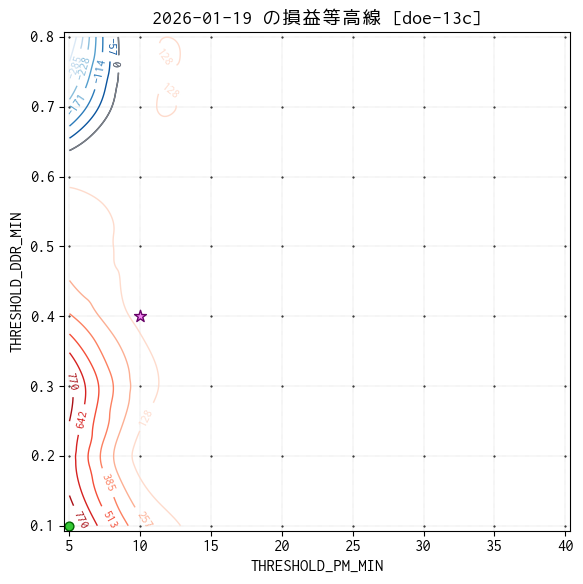

In [10]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

try:
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

try:
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

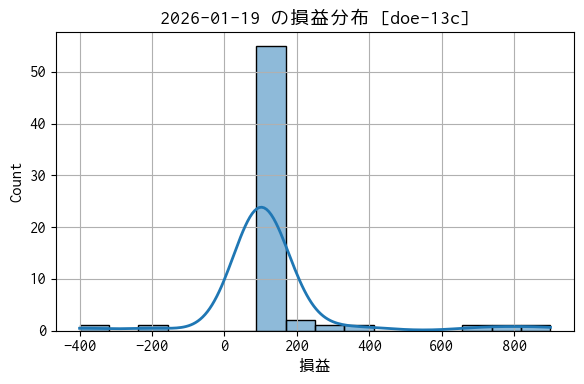

In [11]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [12]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                     file  code  trade   total  THRESHOLD_PM_MIN  \
6274  ticks_20260115.xlsx  7203     44  8400.0              15.0   

      THRESHOLD_DDR_MIN  
6274                0.1  

最低損益
                     file  code  trade    total  THRESHOLD_PM_MIN  \
3335  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3343  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3351  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3359  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3367  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3375  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3383  ticks_20251105.xlsx  7203     68 -14800.0              40.0   
3391  ticks_20251105.xlsx  7203     68 -14800.0              40.0   

      THRESHOLD_DDR_MIN  
3335                0.1  
3343                0.2  
3351                0.3  
3359                0.4  
3367                0.5  
3375                0.

## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
                0       1       2       3       4       5       6       7   \
2025-08-19  3050.0  2750.0  3900.0  4450.0  4350.0  4950.0  4550.0  4550.0   
2025-08-20    50.0   750.0   450.0   450.0   450.0   450.0   450.0   450.0   
2025-08-21  -150.0  -150.0  -150.0  -150.0  -150.0  -150.0  -150.0  -150.0   
2025-08-22   500.0   350.0   350.0   350.0   350.0   350.0   350.0   350.0   
2025-08-25   300.0   300.0   200.0   200.0   200.0   200.0   200.0   200.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-13 -2200.0 -1000.0 -1000.0 -1000.0   100.0   100.0 -1000.0 -1000.0   
2026-01-14  3300.0  2300.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
2026-01-15   500.0  2400.0  8400.0  6800.0  6800.0  6800.0  6800.0  6800.0   
2026-01-16 -5100.0 -4700.0 -3800.0 -3200.0 -3100.0 -4200.0 -4200.0 -4200.0   
2026-01-19   900.0   300.0   100.0   100.0   100.0   100.0   100.0   100.0   

                8       9   ...      54    

## 損益の移動平均のトレンド

In [14]:
# 移動平均
df_ma = df_raw.rolling(window=period, min_periods=1).mean()
print(df_ma)
# データスコープを示す文字列
dt_start = df_ma.index[0]
dt_end = df_ma.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {dt_start.date()} to {dt_end.date()} / "
    f"n={n_day}d / "
    f"rolling={period}d"
)
print("データスコープを示す文字列")
print(title_scope)

                     0            1       2            3       4       5   \
2025-08-19  3050.000000  2750.000000  3900.0  4450.000000  4350.0  4950.0   
2025-08-20  1550.000000  1750.000000  2175.0  2450.000000  2400.0  2700.0   
2025-08-21   983.333333  1116.666667  1400.0  1583.333333  1550.0  1750.0   
2025-08-22   862.500000   925.000000  1137.5  1275.000000  1250.0  1400.0   
2025-08-25   750.000000   800.000000   950.0  1060.000000  1040.0  1160.0   
...                 ...          ...     ...          ...     ...     ...   
2026-01-13    32.000000   212.000000   216.0   184.000000   160.0   148.0   
2026-01-14   184.000000   296.000000   276.0   244.000000   220.0   208.0   
2026-01-15   240.000000   400.000000   632.0   536.000000   512.0   500.0   
2026-01-16    36.000000   192.000000   448.0   384.000000   364.0   308.0   
2026-01-19    48.000000   160.000000   416.0   352.000000   332.0   276.0   

                     6            7       8            9   ...           54

### ランキング（移動平均）

In [15]:
# 最終日の移動平均収益のランキング
ser_ma_ranking = df_ma.iloc[len(df_ma) - 1].sort_values(ascending=False)
n_top = 5

# ベスト条件の抽出
best_ma_conditions = list(ser_ma_ranking.index[:n_top])
df_ma_best = df_latest.iloc[best_ma_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_ma.index[-1]
df_ma_best["損益(MA)"] = (df_ma.loc[dt:][best_ma_conditions].T)[dt]
print("---\n[Best Conditions with latest MA]")
print(df_ma_best)

# HTML 形式で出力
styled = (
    df_ma_best.style.format(
        {
            col_x: "{:.1f}",
            col_y: "{:.1f}",
            "取引回数": "{:.0f}",
            "損益": "{:.1f}",
            "損益(MA)": "{:.1f}",
        }
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_ma_conditions = ser_ma_ranking[ser_ma_ranking < 0].index
if len(negative_ma_conditions) > 0:
    df_ma_negative = df_latest.iloc[negative_ma_conditions].copy()
    df_ma_negative["損益(MA)"] = (df_ma.loc[dt:][negative_ma_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MA]")
    print(df_ma_negative)

---
[Best Conditions with latest MA]
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN  取引回数     損益  損益(MA)
2               15.0                0.1    26  100.0   416.0
10              15.0                0.2    26  100.0   372.0
3               20.0                0.1    26  100.0   352.0
25              10.0                0.4    26  100.0   352.0
4               25.0                0.1    26  100.0   332.0


### 条件毎の損益トレンド（移動平均）のチャート

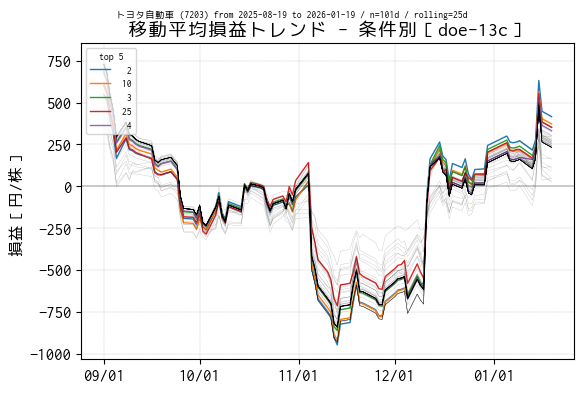

In [16]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_ma[dt_from <= df_ma.index]

for colname in ser_ma_ranking.index:
    if colname in best_ma_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_ma_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動平均損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_ma_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益の移動メジアンのトレンド

In [17]:
# 移動メジアン
df_mm = df_raw.rolling(window=period, min_periods=1).median()
print(df_mm)

                0       1       2       3       4       5       6       7   \
2025-08-19  3050.0  2750.0  3900.0  4450.0  4350.0  4950.0  4550.0  4550.0   
2025-08-20  1550.0  1750.0  2175.0  2450.0  2400.0  2700.0  2500.0  2500.0   
2025-08-21    50.0   750.0   450.0   450.0   450.0   450.0   450.0   450.0   
2025-08-22   275.0   550.0   400.0   400.0   400.0   400.0   400.0   400.0   
2025-08-25   300.0   350.0   350.0   350.0   350.0   350.0   350.0   350.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-13   200.0   400.0   400.0   400.0   400.0   400.0   400.0   400.0   
2026-01-14   200.0   400.0   400.0   400.0   400.0   400.0   400.0   400.0   
2026-01-15   500.0   500.0   500.0   400.0   400.0   400.0   400.0   400.0   
2026-01-16   500.0   400.0   400.0   400.0   400.0   400.0   400.0   400.0   
2026-01-19   500.0   400.0   400.0   400.0   400.0   400.0   400.0   400.0   

                8       9   ...      54      55      56      57

### ランキング（移動メジアン）

In [18]:
# 最終日の移動メジアン収益のランキング
ser_mm_ranking = df_mm.iloc[len(df_mm) - 1].sort_values(ascending=False)
n_top = 10

# ベスト条件の抽出
best_mm_conditions = list(ser_mm_ranking.index[:n_top])
df_mm_best = df_latest.iloc[best_mm_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_mm.index[-1]
df_mm_best["損益(MM)"] = (df_mm.loc[dt:][best_mm_conditions].T)[dt]
print("---\n[Best Conditions with latest MM]")
print(df_mm_best)

# HTML 形式で出力
styled = (
    df_mm_best.style.format(
        {
            col_x: "{:.1f}",
            col_y: "{:.1f}",
            "取引回数": "{:.0f}",
            "損益": "{:.1f}",
            "損益(MM)": "{:.1f}",
        }
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_mm_conditions = ser_mm_ranking[ser_mm_ranking < 0].index
if len(negative_mm_conditions) > 0:
    df_mm_negative = df_latest.iloc[negative_mm_conditions].copy()
    df_mm_negative["損益(MM)"] = (df_mm.loc[dt:][negative_mm_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MM]")
    print(df_mm_negative)

---
[Best Conditions with latest MM]
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN  取引回数     損益  損益(MM)
8                5.0                0.2    26  700.0   600.0
16               5.0                0.3    26  800.0   600.0
24               5.0                0.4    26  400.0   500.0
0                5.0                0.1    26  900.0   500.0
4               25.0                0.1    26  100.0   400.0
5               30.0                0.1    26  100.0   400.0
2               15.0                0.1    26  100.0   400.0
1               10.0                0.1    26  300.0   400.0
7               40.0                0.1    26  100.0   400.0
9               10.0                0.2    26  100.0   400.0


### 条件毎の損益トレンド（移動メジアン）のチャート

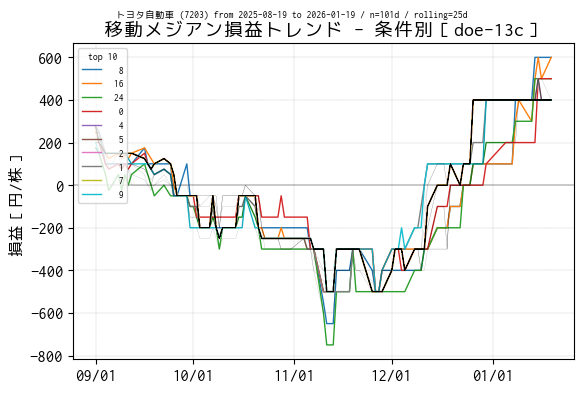

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均メジアントレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

df_trend = df_mm[dt_from <= df_mm.index]

for colname in ser_mm_ranking.index:
    if colname in best_mm_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_mm_conditions:  # 最新のメジアン収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動メジアン損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_mm_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

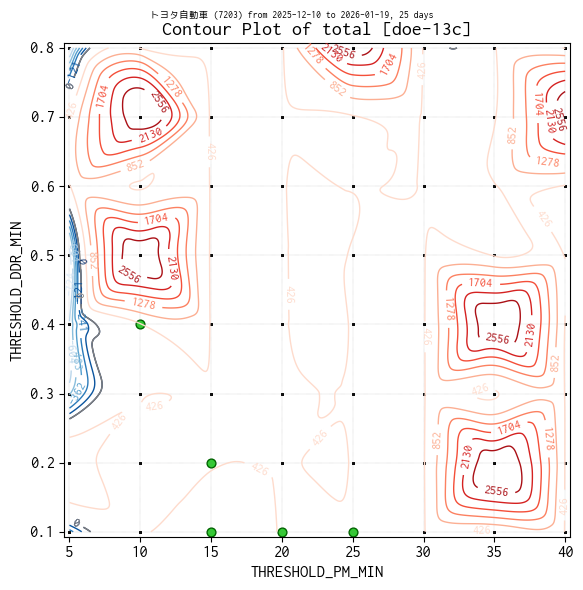

In [20]:
n = len(df_doe) * period
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "total"
x = df[col_x][-n:]
y = df[col_y][-n:]
z = df[col_z][-n:]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_ma_best[col_x],
    df_ma_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
if len(negative_ma_conditions) > 0:
    ax.scatter(
        df_ma_negative[col_x],
        df_ma_negative[col_y],
        marker="x",
        color="black",
        s=60,
        zorder=1,
    )

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

title_scope_2 = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {df_ma.index[-period].date()} to {dt_end.date()}, {period} days"
)

plt.suptitle(title_scope_2, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()